## Knuth miles data analyses from source

`miles_graph()` returns an undirected graph over 128 US cities. The
cities each have location and population data.  The edges are labeled with the
distance between the two cities.

This example is described in Section 1.1 of

    Donald E. Knuth, "The Stanford GraphBase: A Platform for Combinatorial
    Computing", ACM Press, New York, 1993.
    http://www-cs-faculty.stanford.edu/~knuth/sgb.html

The data file can be found at:

- https://github.com/networkx/networkx/blob/main/examples/drawing/knuth_miles.txt.gz

In [1]:
import gzip
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Ignore any warnings related to downloading shpfiles with cartopy
import warnings

warnings.simplefilter("ignore")

def miles_graph():
    """Return the cites example graph in miles_dat.txt
    from the Stanford GraphBase.
    """
    # open file miles_dat.txt.gz (or miles_dat.txt)
    fh = gzip.open("../data/knuth_miles.txt.gz", "r")

    G = nx.Graph()
    G.position = {}
    G.population = {}

    cities = []
    for line in fh.readlines():
        line = line.decode()
        if line.startswith("*"):  # skip comments
            continue

        numfind = re.compile(r"^\d+")

        if numfind.match(line):  # this line is distances
            dist = line.split()
            for d in dist:
                G.add_edge(city, cities[i], weight=int(d))
                i = i + 1
        else:  # this line is a city, position, population
            i = 1
            (city, coordpop) = line.split("[")
            cities.insert(0, city)
            (coord, pop) = coordpop.split("]")
            (y, x) = coord.split(",")

            G.add_node(city)
            # assign position - Convert string to lat/long
            G.position[city] = (-float(x) / 100, float(y) / 100)
            G.population[city] = float(pop) / 1000
    return G


In [2]:
G = miles_graph()
print("Loaded miles_dat.txt containing 128 cities.")
print(G)

Loaded miles_dat.txt containing 128 cities.
Graph with 128 nodes and 8128 edges


### Convert G to Pandas DataFrame

In [3]:
df_cities = pd.DataFrame(G.position).T
df_cities.index.name = 'city'
df_cities.columns = ['longitude', 'latitude']
df_cities['population'] = G.population
df_cities.reset_index(inplace=True)

In [4]:
df_cities.head()

,city,longitude,latitude,population
0,"Youngstown, OH",-80.65,41.10,115.436
1,"Yankton, SD",-97.39,42.88,12.011
2,"Yakima, WA",-120.51,46.60,49.826
3,"Worcester, MA",-71.80,42.27,161.799
4,"Wisconsin Dells, WI",-89.77,43.63,2.521


In [5]:
df_cities.to_csv('../data/Node_cities.csv', index=False)

### Convert Edge to DataFrame


In [6]:
# Assuming G is your graph
edges = G.edges(data=True)

# Create a DataFrame from the edge list
df_edges = pd.DataFrame(
    [(u, v, d['weight']) for u, v, d in edges],
    columns=['source', 'target', 'weight']
)

# Create a pivot table (distance matrix)
distance_matrix = df_edges.pivot(index='source', columns='target', values='weight')

# Since the graph is undirected, also fill the transpose
distance_matrix_full = distance_matrix.combine_first(distance_matrix.T)

# Optionally, fill NaNs if you want (e.g., with 0 or np.inf)
distance_matrix_full = distance_matrix_full.fillna(0)
distance_matrix_full.to_csv('../data/edges.csv')

## 1. Geographic Distribution Analysis

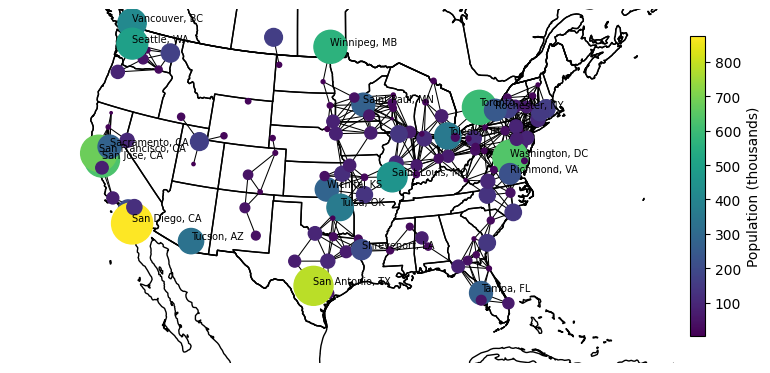

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

# make new graph of cites, edge if less than 300 miles between them
H = nx.Graph()
for v in G:
    H.add_node(v)
for u, v, d in G.edges(data=True):
    if d["weight"] < 300:
        H.add_edge(u, v)

fig = plt.figure(figsize=(8, 6))

# nodes colored by degree sized by population
node_color = [float(G.population[v]) for v in H]
# Normalize and colormap
norm = mcolors.Normalize(vmin=min(node_color), vmax=max(node_color))
cmap = cm.viridis  # or any colormap like 'plasma', 'coolwarm', etc.
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Needed for colorbar
# Use cartopy to provide a backdrop for the visualization

ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(), frameon=False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# Add map of countries & US states as a backdrop
for shapename in ("admin_1_states_provinces", "admin_0_countries"):
    shp = shpreader.natural_earth(
        resolution="50m", category="cultural", name=shapename
    )
    ax.add_geometries(
        shpreader.Reader(shp).geometries(),
        ccrs.PlateCarree(),
        facecolor="none",
        edgecolor="k",
    )

# NOTE: When using cartopy, use matplotlib directly rather than nx.draw
# to take advantage of the cartopy transforms
ax.scatter(
    *np.array(list(G.position.values())).T,
    s=[G.population[v] for v in H],
    c=node_color,                         # Color by some variable
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    zorder=100,  # Ensure nodes lie on top of edges/state lines
)
# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.02)
cbar.set_label('Population (thousands)')  # Or your preferred label

# Plot edges between the cities
for edge in H.edges():
    edge_coords = np.array([G.position[v] for v in edge])
    ax.plot(
        edge_coords[:, 0],
        edge_coords[:, 1],
        transform=ccrs.PlateCarree(),
        linewidth=0.75,
        color="k",
    )

# Step 1: Sort top 10 cities by population
top_20 = sorted(H.nodes, key=lambda v: G.population[v], reverse=True)[:20]

# Step 2: Add labels to the plot
for city in top_20:
    lon, lat = G.position[city]
    ax.text(
        lon,
        lat,
        city,
        transform=ccrs.PlateCarree(),
        fontsize=7,
        ha='left',
        va='bottom',
        zorder=100,
    )
plt.show()

## 2. Population Analysis

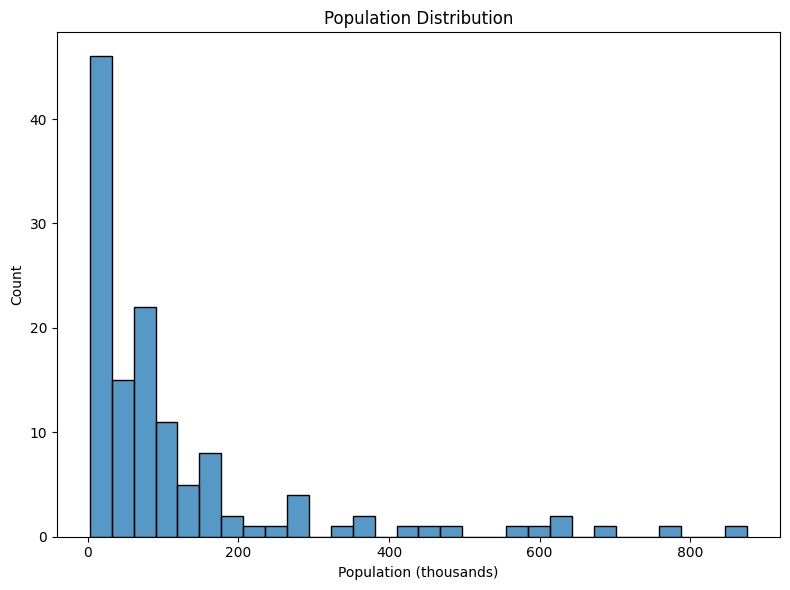

Population Statistics:
Mean: 120
Median: 68
Std Dev: 167
Min: 3
Max: 876


In [8]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
populations = [G.population[v] for v in G]
# Population distribution
sns.histplot(populations, bins=30)
plt.title('Population Distribution')
plt.xlabel('Population (thousands)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Population statistics
print(f"Population Statistics:")
print(f"Mean: {np.mean(populations):,.0f}")
print(f"Median: {np.median(populations):,.0f}")
print(f"Std Dev: {np.std(populations):,.0f}")
print(f"Min: {np.min(populations):,.0f}")
print(f"Max: {np.max(populations):,.0f}")

## 3. Centrality Analysis

In [9]:
# Centrality Measures
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G,distance='weight')
betweenness = nx.betweenness_centrality(G,weight='weight')

In [11]:
city_names = closeness.keys()

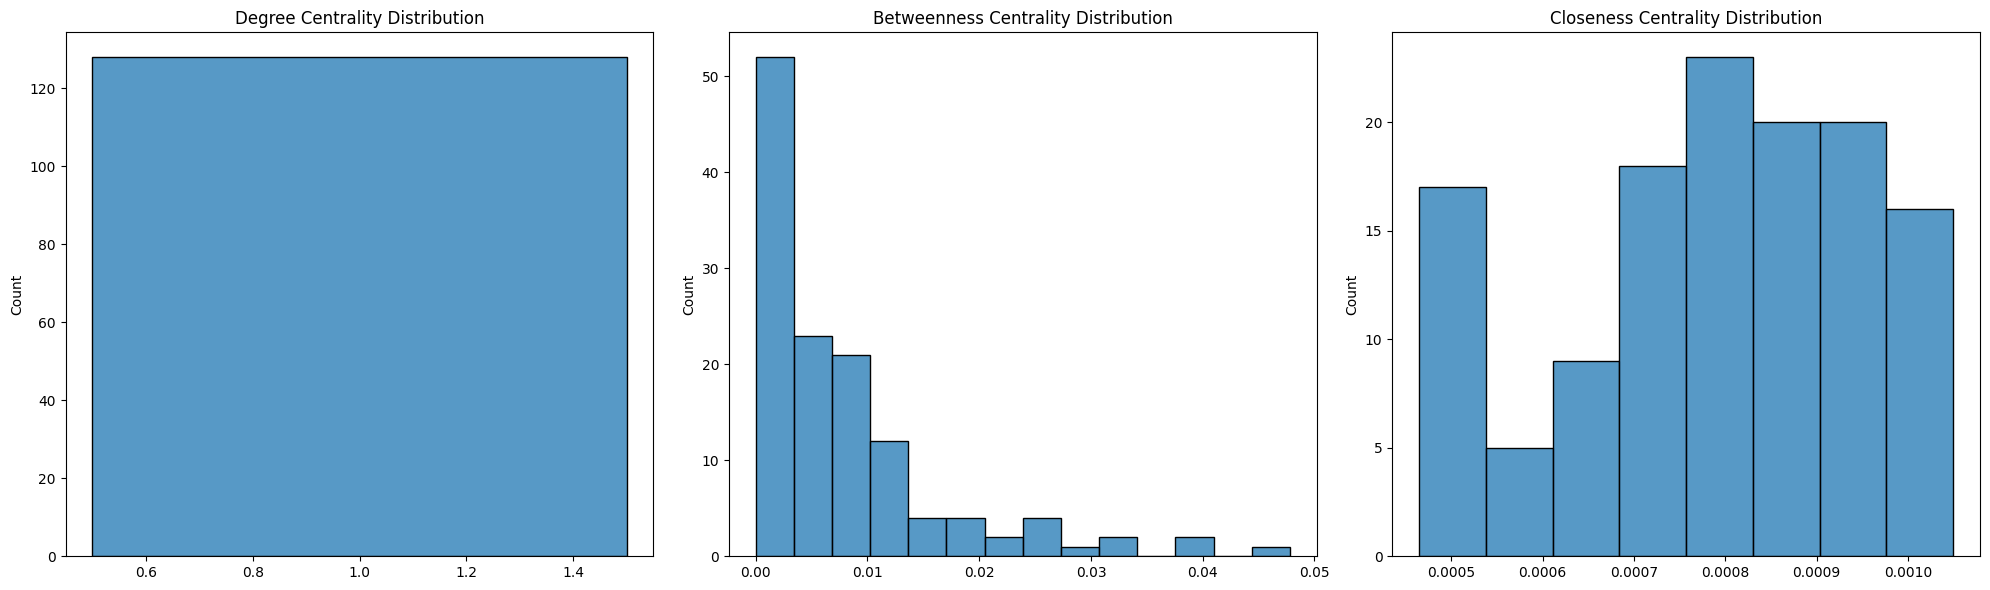


Top 5 cities by Degree Centrality:
Youngstown, OH: 1.0000
Yankton, SD: 1.0000
Yakima, WA: 1.0000
Worcester, MA: 1.0000
Wisconsin Dells, WI: 1.0000

Top 5 cities by Betweenness Centrality:
Rock Springs, WY: 0.0478
Saint Paul, MN: 0.0403
Salt Lake City, UT: 0.0394
Richmond, IN: 0.0335
Terre Haute, IN: 0.0332

Top 5 cities by Closeness Centrality:
Springfield, IL: 0.0010
Saint Louis, MO: 0.0010
Terre Haute, IN: 0.0010
Vincennes, IN: 0.0010
Rockford, IL: 0.0010


In [12]:
# Create DataFrame for centrality measures
centrality_data = []

for city in city_names:
    centrality_data.append({
        'City': city,
        'Degree': degree[city],
        'Betweenness': betweenness[city],
        'Closeness': closeness[city]
    })

# Plot centrality distributions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot([d['Degree'] for d in centrality_data], ax=ax1)
ax1.set_title('Degree Centrality Distribution')

sns.histplot([d['Betweenness'] for d in centrality_data], ax=ax2)
ax2.set_title('Betweenness Centrality Distribution')

sns.histplot([d['Closeness'] for d in centrality_data], ax=ax3)
ax3.set_title('Closeness Centrality Distribution')

plt.tight_layout()
plt.show()

# Print top 5 cities by each centrality measure
print("\nTop 5 cities by Degree Centrality:")
for city in sorted(centrality_data, key=lambda x: x['Degree'], reverse=True)[:5]:
    print(f"{city['City']}: {city['Degree']:.4f}")

print("\nTop 5 cities by Betweenness Centrality:")
for city in sorted(centrality_data, key=lambda x: x['Betweenness'], reverse=True)[:5]:
    print(f"{city['City']}: {city['Betweenness']:.4f}")

print("\nTop 5 cities by Closeness Centrality:")
for city in sorted(centrality_data, key=lambda x: x['Closeness'], reverse=True)[:5]:
    print(f"{city['City']}: {city['Closeness']:.4f}")

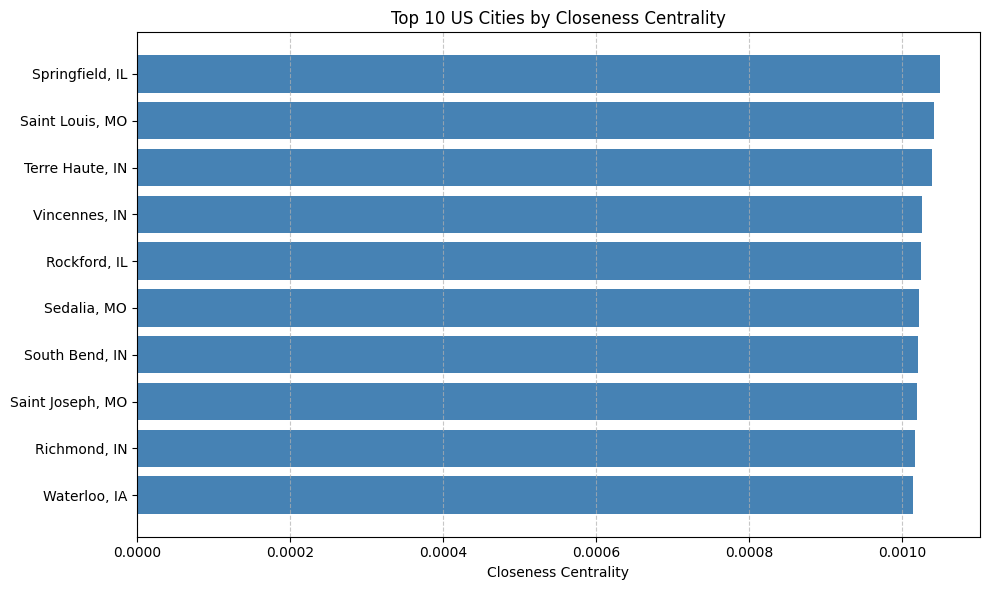

In [13]:
df_closeness = pd.DataFrame(list(closeness.items()), columns=["City", "ClosenessCentrality"])

# Get top 10 cities by closeness centrality
top_10 = df_closeness.sort_values(by="ClosenessCentrality", ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10["City"], top_10["ClosenessCentrality"], color='steelblue')
plt.xlabel("Closeness Centrality")
plt.title("Top 10 US Cities by Closeness Centrality")
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

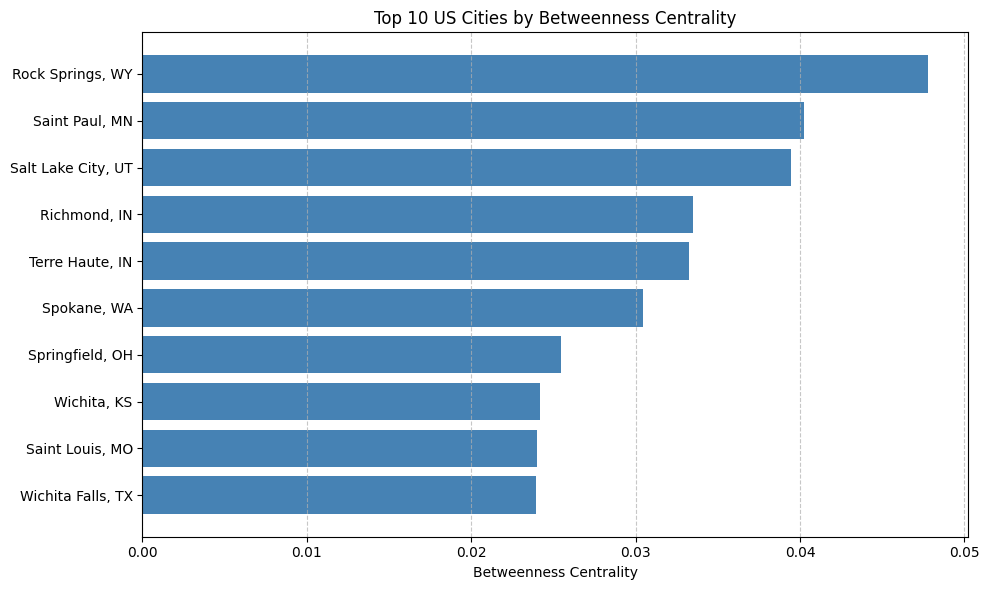

In [14]:
df_betweeness = pd.DataFrame(list(betweenness.items()), columns=["City", "BetweennessCentrality"])

# Get top 10 cities by closeness centrality
top_10 = df_betweeness.sort_values(by="BetweennessCentrality", ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10["City"], top_10["BetweennessCentrality"], color='steelblue')
plt.xlabel("Betweenness Centrality")
plt.title("Top 10 US Cities by Betweenness Centrality")
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [30]:
df_edges

,"Ravenna, OH","Reading, PA","Red Bluff, CA","Regina, SK","Reno, NV","Rhinelander, WI","Richfield, UT","Richmond, IN","Richmond, VA","Roanoke, VA",...,"Wilmington, DE","Wilmington, NC","Winchester, VA","Winnipeg, MB","Winston-Salem, NC","Wisconsin Dells, WI","Worcester, MA","Yakima, WA","Yankton, SD","Youngstown, OH"
"Ravenna, OH",0.0,348.0,2541.0,1570.0,2343.0,691.0,1943.0,246.0,413.0,405.0,...,370.0,660.0,270.0,1249.0,506.0,565.0,619.0,2380.0,936.0,34.0
"Reading, PA",348.0,0.0,2871.0,1917.0,2673.0,1038.0,2243.0,543.0,249.0,345.0,...,57.0,496.0,164.0,1596.0,454.0,912.0,307.0,2727.0,1283.0,321.0
"Red Bluff, CA",2541.0,2871.0,0.0,1564.0,198.0,2217.0,769.0,2352.0,2917.0,2784.0,...,2893.0,3040.0,2792.0,1963.0,2847.0,2154.0,3125.0,610.0,1694.0,2571.0
"Regina, SK",1570.0,1917.0,1564.0,0.0,1458.0,943.0,1211.0,1437.0,1974.0,1865.0,...,1939.0,2146.0,1831.0,399.0,1932.0,1007.0,2154.0,1047.0,782.0,1600.0
"Reno, NV",2343.0,2673.0,198.0,1458.0,0.0,2019.0,571.0,2154.0,2719.0,2586.0,...,2695.0,2842.0,2594.0,1774.0,2649.0,1956.0,2927.0,710.0,1496.0,2373.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Wisconsin Dells, WI",565.0,912.0,2154.0,1007.0,1956.0,170.0,1565.0,432.0,969.0,860.0,...,934.0,1139.0,826.0,686.0,927.0,0.0,1149.0,1817.0,481.0,595.0
"Worcester, MA",619.0,307.0,3125.0,2154.0,2927.0,1275.0,2536.0,841.0,518.0,646.0,...,299.0,765.0,466.0,1833.0,729.0,1149.0,0.0,2964.0,1520.0,604.0
"Yakima, WA",2380.0,2727.0,610.0,1047.0,710.0,1815.0,942.0,2247.0,2784.0,2675.0,...,2749.0,2956.0,2641.0,1446.0,2742.0,1817.0,2964.0,0.0,1513.0,2410.0
"Yankton, SD",936.0,1283.0,1694.0,782.0,1496.0,550.0,1113.0,794.0,1340.0,1221.0,...,1305.0,1500.0,1197.0,550.0,1289.0,481.0,1520.0,1513.0,0.0,966.0


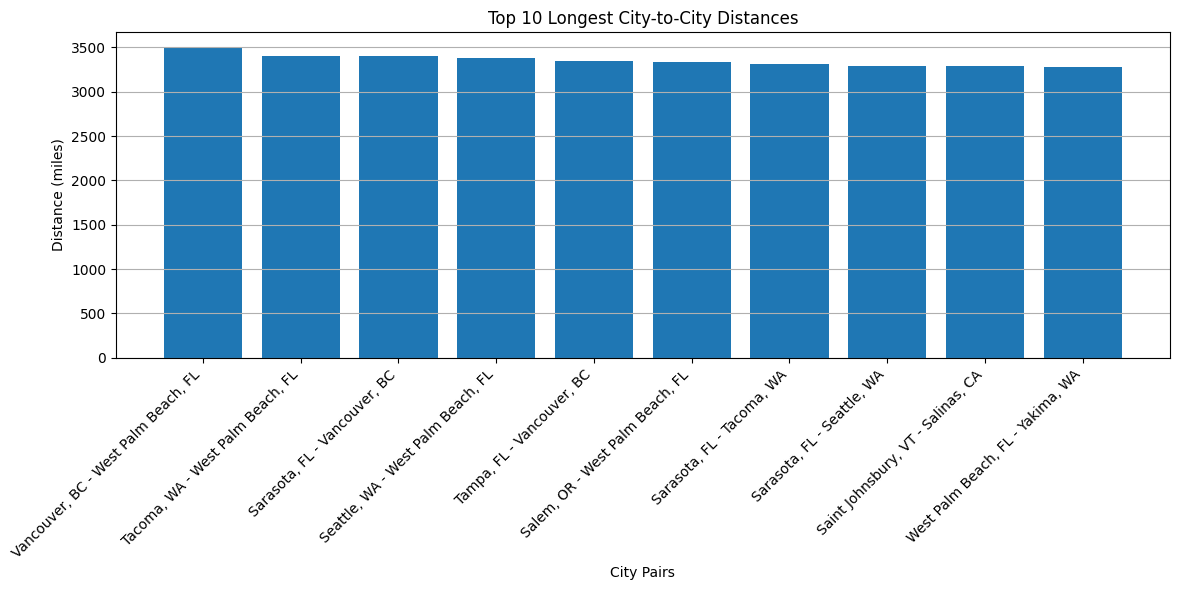

In [31]:

# Extract all city pairs with their distances
city_distances = []
for source in df_edges.index:
    for target in df_edges.columns:
        value = df_edges.loc[source, target]
        if pd.notna(value) and source != target:
            city_distances.append((source, target, value))

# Remove duplicates (treating the graph as undirected)
seen = set()
unique_city_distances = []
for src, tgt, dist in city_distances:
    key = tuple(sorted([src, tgt]))
    if key not in seen:
        seen.add(key)
        unique_city_distances.append((src, tgt, dist))

# Sort and get top 10 distances
top_10_distances = sorted(unique_city_distances, key=lambda x: x[2], reverse=True)[:10]

# Prepare data for plotting
city_labels = [f"{src} - {tgt}" for src, tgt, _ in top_10_distances]
distance_values = [dist for _, _, dist in top_10_distances]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(city_labels, distance_values)
plt.ylabel('Distance (miles)')
plt.xlabel('City Pairs')
plt.title('Top 10 Longest City-to-City Distances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


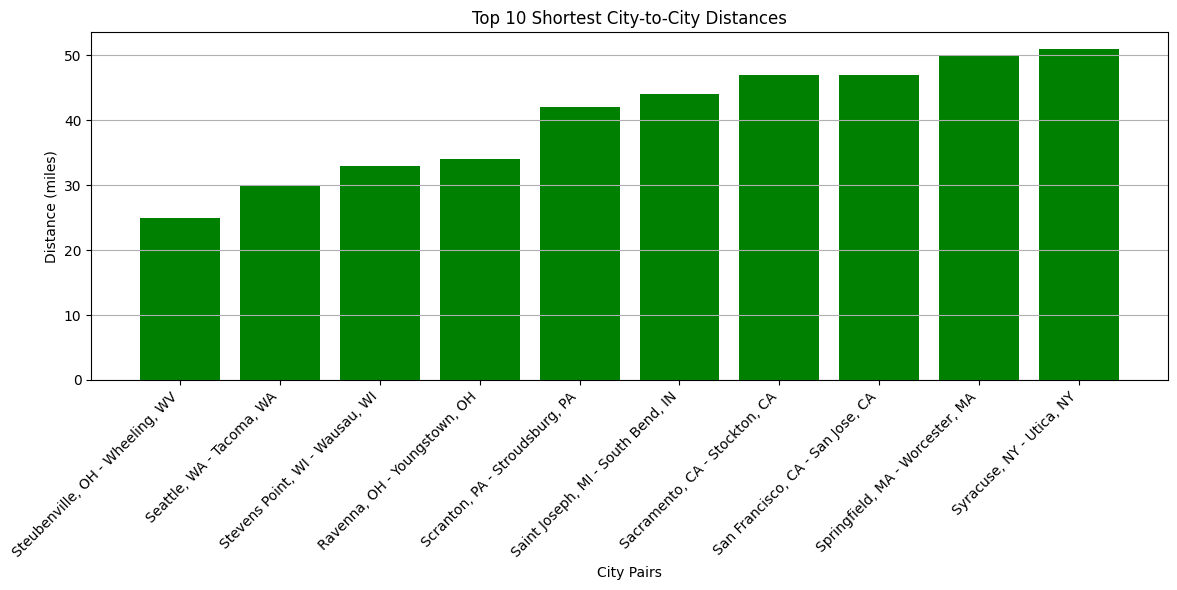

In [32]:
# Sort and get top 10 shortest non-zero distances
top_10_shortest = sorted(unique_city_distances, key=lambda x: x[2])[:10]

# Prepare data for plotting
city_labels_short = [f"{src} - {tgt}" for src, tgt, _ in top_10_shortest]
distance_values_short = [dist for _, _, dist in top_10_shortest]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(city_labels_short, distance_values_short, color='green')
plt.ylabel('Distance (miles)')
plt.xlabel('City Pairs')
plt.title('Top 10 Shortest City-to-City Distances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()
